In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, silhouette_score, pairwise_distances

In [2]:
# Functions used in the code
def class_balance(df_temp, target_col):
    sns.countplot(x=df_temp[target_col])
    column_values = df_temp[target_col].values.ravel()
    unique_values = pd.unique(column_values)
    for value in unique_values:
        print(value,":",(len(df_temp.loc[df_temp[target_col] == value]) / len(df_temp)) * 100, "%")
    return (len(df_temp.loc[df_temp[target_col] == value]) / len(df_temp)) * 100
def train_test_model(RF_classifier, stratified_kfolds, features, labels):
    actual_class = np.empty([0], dtype=int)
    predicted_class = np.empty([0], dtype=int)
    
    for train_index, test_index in stratified_kfolds.split(features, labels):
        RF_classifier.fit(features.iloc[train_index], labels.iloc[train_index])

        actual_class = np.append(actual_class, labels.iloc[test_index])
        predicted_class = np.append(predicted_class, RF_classifier.predict(features.iloc[test_index]))
    
    return actual_class, predicted_class

def features_labels(dataset, label_column):
    return dataset.drop(label_column, axis=1), dataset[label_column]

def calculate_confusion_matrix(actual_class, predicted_class, labels):
    matrix = confusion_matrix(actual_class, predicted_class, labels=labels)
    confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
    fig, ax = plt.subplots(figsize=(8,8))
    confusion_matrix_display.plot(cmap=plt.cm.Blues, ax=ax)


def elbowMethodResult(features):
    k_metrices = {}
    for k in range(2, 11):
        kmean_classifier = KMeans(n_clusters=k).fit(features)
        k_metrices[k] = kmean_classifier.inertia_
    
    plot_Kmeans_Data(k_metrices, technique="Elbow Method")
        

def avgSilhouteMethodResult(features):
    k_metrices = {}
    for k in range(2, 11):
        kmean_classifier = KMeans(n_clusters=k)
        kmean_cluster = kmean_classifier.fit_predict(features)
        avg_score = silhouette_score(features, kmean_cluster)
        
        k_metrices[k] = avg_score
    
    plot_Kmeans_Data(k_metrices, technique="Silhoute Method")
    
def plot_Kmeans_Data(metrics_info, technique=""):

    k_values = [k for k, _ in metrics_info.items()]
    k_scores = [score for _, score in metrics_info.items()]

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(k_values, k_scores, color="red", marker='o')

    plt.xlabel("number of Clusters")
    plt.ylabel("score")
    ax.set_title(f"{technique} for finding best value of K")
    ax.set_xticks(k_values)
    
    ax.grid(color="grey", linestyle='-', linewidth=0.3, alpha=0.85)
    
def ClusterInformation(kMeansClf, features, labels, distance_threshold):
    clusters_closets = pairwise_distances(kMeansClf.cluster_centers_, features)
    cluster_details = []
    
    for cluster in range(kMeansClf.n_clusters):
        cluster_detailed_info = {}
        data_indices_in_cluster = []
        index = 0
        cluster_detailed_info["K"] = cluster + 1
        cluster_detailed_info["centroid"] = kMeansClf.cluster_centers_[cluster]

        for point in clusters_closets[cluster]:
            if point <= distance_threshold:
                data_indices_in_cluster.append(index)
            index += 1

        #Unique Classes in cluster
        labels_data = labels.iloc[data_indices_in_cluster]
        unique_classes = np.unique(labels_data)
        cluster_detailed_info["total_classes"] = unique_classes
        try:
            if len(unique_classes) > 1:
                labels_info = {}
                for label in unique_classes:
                    labels_info[label] = len(labels_data[labels_data == label])
                labels_info = sorted(labels_info.items(), key=lambda x:x[1])

                cluster_detailed_info["minority_class"] = labels_info[0][0]
                cluster_detailed_info["minority_class_count"] = labels_info[0][1]

                features_data = features.iloc[data_indices_in_cluster]

                classifier = trainRandomForestClassifier(features_data, labels_data)
                cluster_detailed_info["classifier"] = classifier

            else:
                cluster_detailed_info["minority_class"] = unique_classes[0]
                cluster_detailed_info["minority_class_count"] = len(labels_data)
                cluster_detailed_info["classifier"] = None
        
        except Exception:
            pass

        cluster_details.append(cluster_detailed_info)
        
    return cluster_details

def UnseenFoldPrediction(kMeansClf, unseen_fold_features, distance_threshold):
    predicted_labels = []
    for feature in unseen_fold_features.to_numpy():
        cluster_distances = pairwise_distances(kMeansClf.cluster_centers_, feature.reshape(1,-1))
        close_clusters = {}
        
        for cluster in range(len(cluster_distances)):
            if cluster_distances[cluster] <= distance_threshold:
                close_clusters[cluster] = cluster_distances[cluster]

        try:
            choosen_cluster = sorted(close_clusters.items(), key=lambda x:x[1])[0]
            if len(cluster_details[choosen_cluster[0]]["total_classes"]) > 1:
                predicted_labels.append(cluster_details[choosen_cluster[0]]["classifier"].predict(feature.reshape(1,-1)))
            else:
                predicted_labels.append(cluster_details[choosen_cluster[0]]["minority_class"])
        except Exception:
            predicted_labels.append(cluster_details[0]["minority_class"])
    
    return predicted_labels

def CleanPredictions(predictions):
    cleaned_pred = []
    for pred in predictions:
        try:
            if type(pred) == list or len(pred) > 0:
                cleaned_pred.append(pred[0])
            else:
                cleaned_pred.append(pred)
        except:
            cleaned_pred.append(pred)
            
    return cleaned_pred

def ClusterInformation(kMeansClf, features, labels, distance_threshold):
    clusters_closets = pairwise_distances(kMeansClf.cluster_centers_, features)
    cluster_details = []
    
    for cluster in range(kMeansClf.n_clusters):
        cluster_detailed_info = {}
        data_indices_in_cluster = []
        index = 0
        cluster_detailed_info["K"] = cluster + 1
        cluster_detailed_info["centroid"] = kMeansClf.cluster_centers_[cluster]

        for point in clusters_closets[cluster]:
            if point <= distance_threshold:
                data_indices_in_cluster.append(index)
            index += 1

        #Unique Classes in cluster
        labels_data = labels.iloc[data_indices_in_cluster]
        print(labels_data)
        unique_classes = np.unique(labels_data)
        cluster_detailed_info["total_classes"] = unique_classes
        
        print(len(unique_classes))
        try:
            if len(unique_classes) > 1:
                labels_info = {}
                for label in unique_classes:
                    labels_info[label] = len(labels_data[labels_data == label])
                labels_info = sorted(labels_info.items(), key=lambda x:x[1])

                cluster_detailed_info["minority_class"] = labels_info[0][0]
                cluster_detailed_info["minority_class_count"] = labels_info[0][1]

                features_data = features.iloc[data_indices_in_cluster]

                classifier = trainRandomForestClassifier(features_data, labels_data)
                cluster_detailed_info["classifier"] = classifier

            else:
                cluster_detailed_info["minority_class"] = unique_classes[0]
                cluster_detailed_info["minority_class_count"] = len(labels_data)
                cluster_detailed_info["classifier"] = None
        
        except Exception:
            pass

        cluster_details.append(cluster_detailed_info)
        
    return cluster_details

In [3]:
stratified_kfolds = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
randomForestClassifier = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=6)

### Heart Attack Analysis & Prediction Dataset

In [4]:
df1 = pd.read_csv("heart-attack-analysis-prediction-dataset/heart.csv")
df1.head(10)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [5]:
df1.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

In [6]:
df1.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [7]:
df1.duplicated().sum()

1

In [8]:
df1.drop_duplicates(keep = 'first', inplace = True)

1 : 54.3046357615894 %
0 : 45.6953642384106 %


45.6953642384106

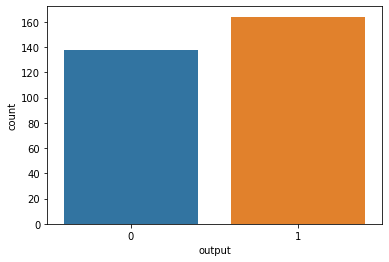

In [9]:
class_balance(df1, "output")

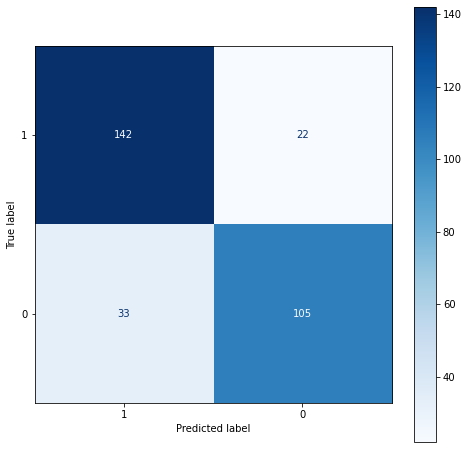

In [10]:
features, labels = features_labels(df1, label_column="output")
#print(labels_df1)
#print(features_df1)

test_labels, pred_labels = train_test_model(randomForestClassifier, stratified_kfolds, features, labels)

calculate_confusion_matrix(test_labels, pred_labels, labels=df1["output"].unique())

In [11]:
stratified_kfolds = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    
unseen_fold_train_indices = np.empty([0], dtype=int)
unseen_fold_test_indices = np.empty([0], dtype=int)
train_fold_indices = np.empty([0], dtype=int)
test_fold_indices = np.empty([0], dtype=int)
    
kFold = 0
for train_index, test_index in stratified_kfolds.split(features, labels):
    if kFold == 0:
        unseen_fold_train_indices = np.append(unseen_fold_train_indices, train_index)
        unseen_fold_test_indices = np.append(unseen_fold_test_indices, test_index)
    else:
        train_fold_indices = np.append(train_fold_indices, train_index)
        test_fold_indices = np.append(test_fold_indices, test_index)
        
    kFold += 1
#print(train_fold_indices)

In [12]:
train_features = features.iloc[train_fold_indices]
train_labels = labels.iloc[train_fold_indices]

unseen_fold_features = features.iloc[unseen_fold_train_indices]
unseen_fold_labels = labels.iloc[unseen_fold_train_indices]

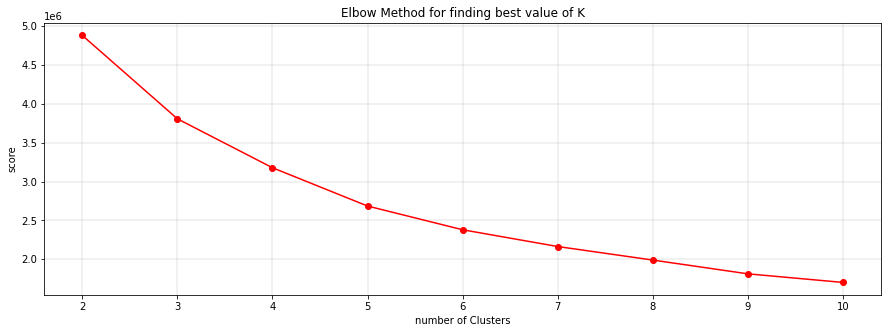

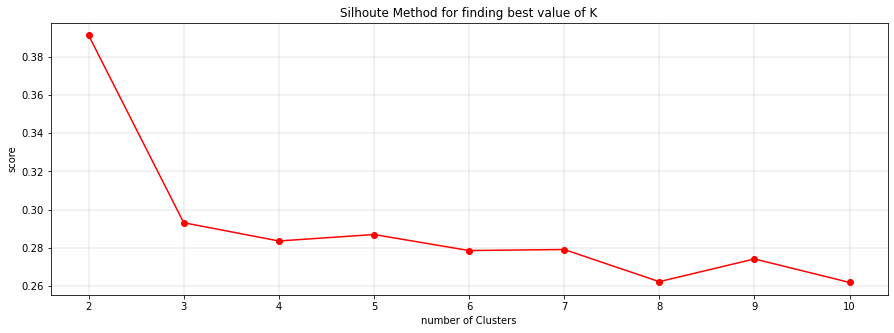

In [13]:
elbowMethodResult(train_features)
avgSilhouteMethodResult(train_features)

In [14]:
kmean_classifier = KMeans(n_clusters=3)
cluster_labels = kmean_classifier.fit(train_features)

In [15]:
cluster_details = ClusterInformation(kmean_classifier, train_features, train_labels, distance_threshold=0.43)
cluster_details

Series([], Name: output, dtype: int64)
0
Series([], Name: output, dtype: int64)
0
Series([], Name: output, dtype: int64)
0


[{'K': 1,
  'centroid': array([5.58511586e+01, 7.08556150e-01, 1.01693405e+00, 1.34292335e+02,
         2.54113191e+02, 1.74688057e-01, 4.12655971e-01, 1.47984848e+02,
         3.54723708e-01, 1.03493761e+00, 1.32531194e+00, 7.72727273e-01,
         2.37522282e+00]),
  'total_classes': array([], dtype=int64)},
 {'K': 2,
  'centroid': array([5.62958716e+01, 5.02293578e-01, 6.99541284e-01, 1.33004587e+02,
         3.26045872e+02, 1.28440367e-01, 5.57339450e-01, 1.50715596e+02,
         3.53211009e-01, 1.16926606e+00, 1.47935780e+00, 8.85321101e-01,
         2.33486239e+00]),
  'total_classes': array([], dtype=int64)},
 {'K': 3,
  'centroid': array([5.18042745e+01, 7.36782902e-01, 1.02699663e+00, 1.27602925e+02,
         1.98021372e+02, 1.28233971e-01, 6.55793026e-01, 1.50969629e+02,
         2.83464567e-01, 9.94713161e-01, 1.44656918e+00, 5.70303712e-01,
         2.22609674e+00]),
  'total_classes': array([], dtype=int64)}]

In [16]:
predictions = UnseenFoldPrediction(kmean_classifier, unseen_fold_features, 0.43)
predictions = CleanPredictions(predictions)
calculate_confusion_matrix(unseen_fold_labels, predictions, labels=df1["output"].unique())

KeyError: 'minority_class'

### Low Imbalance (65%)

In [17]:
output = df1.index[df1["output"] == 0]

In [18]:
LID1 = df1.drop(output[:int(len(output) * 0.363)])

In [19]:
LID1

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


1 : 65.07936507936508 %
0 : 34.92063492063492 %


34.92063492063492

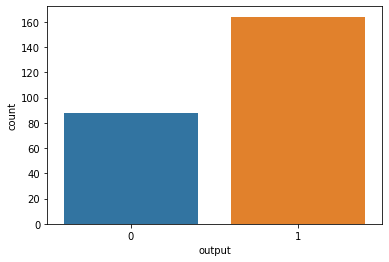

In [20]:
class_balance(LID1, "output")

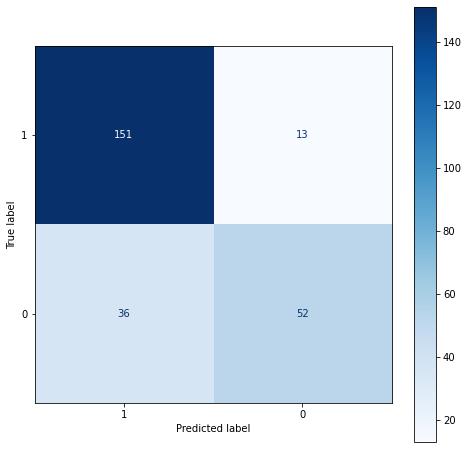

In [21]:
features, labels = features_labels(LID1, label_column="output")
#print(labels_df1)
#print(features_df1)

test_labels, pred_labels = train_test_model(randomForestClassifier, stratified_kfolds, features, labels)

calculate_confusion_matrix(test_labels, pred_labels, labels=LID1["output"].unique())

In [22]:
stratified_kfolds = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    
unseen_fold_train_indices = np.empty([0], dtype=int)
unseen_fold_test_indices = np.empty([0], dtype=int)
train_fold_indices = np.empty([0], dtype=int)
test_fold_indices = np.empty([0], dtype=int)
    
kFold = 0
for train_index, test_index in stratified_kfolds.split(features, labels):
    if kFold == 0:
        unseen_fold_train_indices = np.append(unseen_fold_train_indices, train_index)
        unseen_fold_test_indices = np.append(unseen_fold_test_indices, test_index)
    else:
        train_fold_indices = np.append(train_fold_indices, train_index)
        test_fold_indices = np.append(test_fold_indices, test_index)
        
    kFold += 1
#print(train_fold_indices)

In [23]:
train_features = features.iloc[train_fold_indices]
train_labels = labels.iloc[train_fold_indices]

unseen_fold_features = features.iloc[unseen_fold_train_indices]
unseen_fold_labels = labels.iloc[unseen_fold_train_indices]

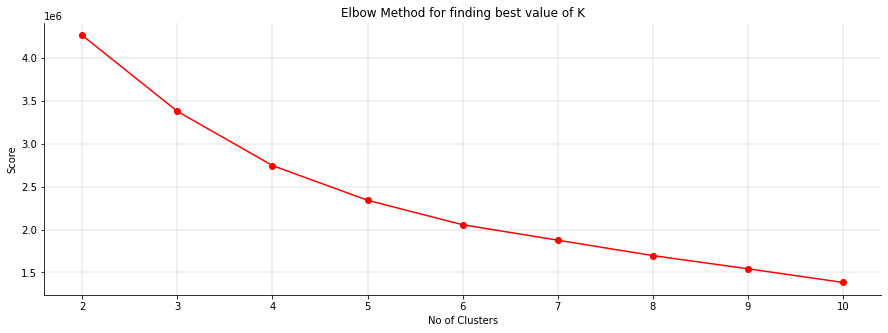

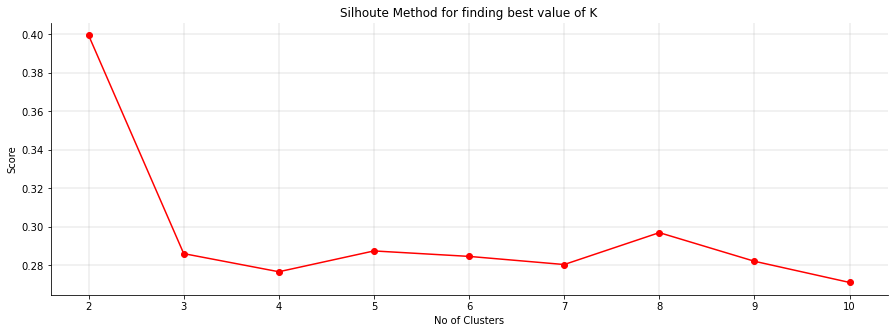

In [24]:
elbowMethodResult(train_features)
avgSilhouteMethodResult(train_features)

In [25]:
kmean_classifier = KMeans(n_clusters=3)
cluster_labels = kmean_classifier.fit(train_features)

In [26]:
cluster_details = ClusterInformation(kmean_classifier, train_features, train_labels, distance_threshold=0.43)
cluster_details

Series([], Name: output, dtype: int64)
0
Series([], Name: output, dtype: int64)
0
Series([], Name: output, dtype: int64)
0


[{'K': 1,
  'centroid': array([5.49843400e+01, 6.59955257e-01, 1.16107383e+00, 1.34549217e+02,
         2.54228188e+02, 1.72259508e-01, 4.46308725e-01, 1.49847875e+02,
         2.98657718e-01, 8.67225951e-01, 1.37472036e+00, 6.45413870e-01,
         2.31655481e+00]),
  'total_classes': array([], dtype=int64)},
 {'K': 2,
  'centroid': array([5.19336801e+01, 7.06111834e-01, 1.12093628e+00, 1.27894668e+02,
         1.98624187e+02, 1.36540962e-01, 7.06111834e-01, 1.51940182e+02,
         2.62678804e-01, 8.32769831e-01, 1.50845254e+00, 4.95448635e-01,
         2.12873862e+00]),
  'total_classes': array([], dtype=int64)},
 {'K': 3,
  'centroid': array([5.62955145e+01, 4.88126649e-01, 7.62532982e-01, 1.32522427e+02,
         3.26931398e+02, 1.47757256e-01, 5.72559367e-01, 1.51110818e+02,
         3.16622691e-01, 1.20105541e+00, 1.50923483e+00, 9.78891821e-01,
         2.29815303e+00]),
  'total_classes': array([], dtype=int64)}]

In [27]:
predictions = UnseenFoldPrediction(kmean_classifier, unseen_fold_features, 0.43)
predictions = CleanPredictions(predictions)
calculate_confusion_matrix(unseen_fold_labels, predictions, labels=LID1["output"].unique())

KeyError: 'minority_class'

### Medium Imbalance (75%)

In [28]:
MID1 = df1.drop(output[:int(len(output) * 0.61)])

In [29]:
MID1

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


1 : 75.22935779816514 %
0 : 24.770642201834864 %


24.770642201834864

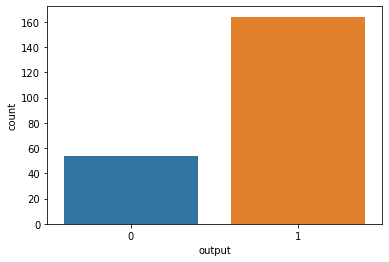

In [30]:
class_balance(MID1, "output")

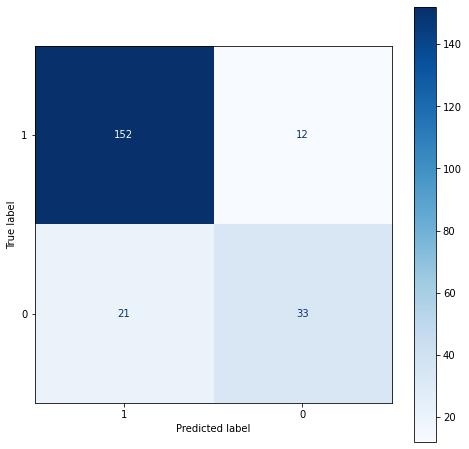

In [31]:
features, labels = features_labels(MID1, label_column="output")
#print(labels_df1)
#print(features_df1)

test_labels, pred_labels = train_test_model(randomForestClassifier, stratified_kfolds, features, labels)

calculate_confusion_matrix(test_labels, pred_labels, labels=MID1["output"].unique())

In [32]:
stratified_kfolds = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    
unseen_fold_train_indices = np.empty([0], dtype=int)
unseen_fold_test_indices = np.empty([0], dtype=int)
train_fold_indices = np.empty([0], dtype=int)
test_fold_indices = np.empty([0], dtype=int)
    
kFold = 0
for train_index, test_index in stratified_kfolds.split(features, labels):
    if kFold == 0:
        unseen_fold_train_indices = np.append(unseen_fold_train_indices, train_index)
        unseen_fold_test_indices = np.append(unseen_fold_test_indices, test_index)
    else:
        train_fold_indices = np.append(train_fold_indices, train_index)
        test_fold_indices = np.append(test_fold_indices, test_index)
        
    kFold += 1
#print(train_fold_indices)

In [33]:
train_features = features.iloc[train_fold_indices]
train_labels = labels.iloc[train_fold_indices]

unseen_fold_features = features.iloc[unseen_fold_train_indices]
unseen_fold_labels = labels.iloc[unseen_fold_train_indices]

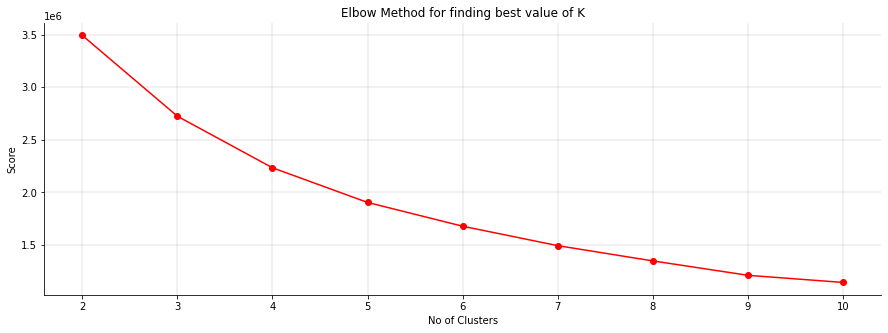

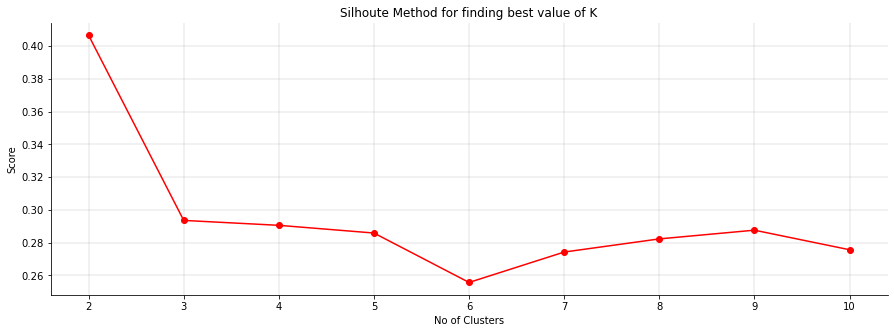

In [34]:
elbowMethodResult(train_features)
avgSilhouteMethodResult(train_features)

In [35]:
kmean_classifier = KMeans(n_clusters=3)
cluster_labels = kmean_classifier.fit(train_features)

In [36]:
cluster_details = ClusterInformation(kmean_classifier, train_features, train_labels, distance_threshold=0.43)
cluster_details

Series([], Name: output, dtype: int64)
0
Series([], Name: output, dtype: int64)
0
Series([], Name: output, dtype: int64)
0


[{'K': 1,
  'centroid': array([5.39743590e+01, 6.55128205e-01, 1.25512821e+00, 1.32108974e+02,
         2.47256410e+02, 1.37179487e-01, 4.89743590e-01, 1.56189744e+02,
         2.17948718e-01, 6.88974359e-01, 1.50256410e+00, 5.34615385e-01,
         2.23846154e+00]),
  'total_classes': array([], dtype=int64)},
 {'K': 2,
  'centroid': array([5.50602410e+01, 4.63855422e-01, 8.46385542e-01, 1.31909639e+02,
         3.21415663e+02, 1.71686747e-01, 6.35542169e-01, 1.48243976e+02,
         3.19277108e-01, 1.11144578e+00, 1.48192771e+00, 7.95180723e-01,
         2.19578313e+00]),
  'total_classes': array([], dtype=int64)},
 {'K': 3,
  'centroid': array([5.20504587e+01, 6.54434251e-01, 1.20030581e+00, 1.27126911e+02,
         1.95957187e+02, 1.60550459e-01, 7.17125382e-01, 1.51547401e+02,
         2.35474006e-01, 8.06727829e-01, 1.50917431e+00, 4.81651376e-01,
         2.10091743e+00]),
  'total_classes': array([], dtype=int64)}]

In [37]:
predictions = UnseenFoldPrediction(kmean_classifier, unseen_fold_features, 0.43)
predictions = CleanPredictions(predictions)
calculate_confusion_matrix(unseen_fold_labels, predictions, labels=MID1["output"].unique())

KeyError: 'minority_class'

### High Imbalance (90%)

In [38]:
HID1 = df1.drop(output[:int(len(output) * 0.87)])

In [39]:
HID1

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


1 : 90.10989010989012 %
0 : 9.89010989010989 %


9.89010989010989

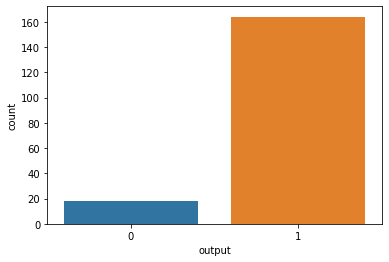

In [40]:
class_balance(HID1, "output")

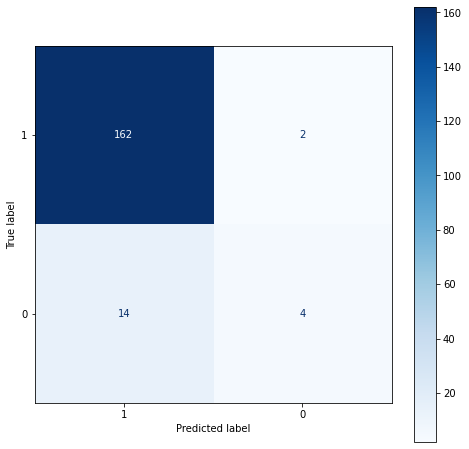

In [41]:
features, labels = features_labels(HID1, label_column="output")
test_labels, pred_labels = train_test_model(randomForestClassifier, stratified_kfolds, features, labels)

calculate_confusion_matrix(test_labels, pred_labels, labels=HID1["output"].unique())

In [42]:
stratified_kfolds = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    
unseen_fold_train_indices = np.empty([0], dtype=int)
unseen_fold_test_indices = np.empty([0], dtype=int)
train_fold_indices = np.empty([0], dtype=int)
test_fold_indices = np.empty([0], dtype=int)
    
kFold = 0
for train_index, test_index in stratified_kfolds.split(features, labels):
    if kFold == 0:
        unseen_fold_train_indices = np.append(unseen_fold_train_indices, train_index)
        unseen_fold_test_indices = np.append(unseen_fold_test_indices, test_index)
    else:
        train_fold_indices = np.append(train_fold_indices, train_index)
        test_fold_indices = np.append(test_fold_indices, test_index)
        
    kFold += 1
#print(train_fold_indices)

In [43]:
train_features = features.iloc[train_fold_indices]
train_labels = labels.iloc[train_fold_indices]

unseen_fold_features = features.iloc[unseen_fold_train_indices]
unseen_fold_labels = labels.iloc[unseen_fold_train_indices]

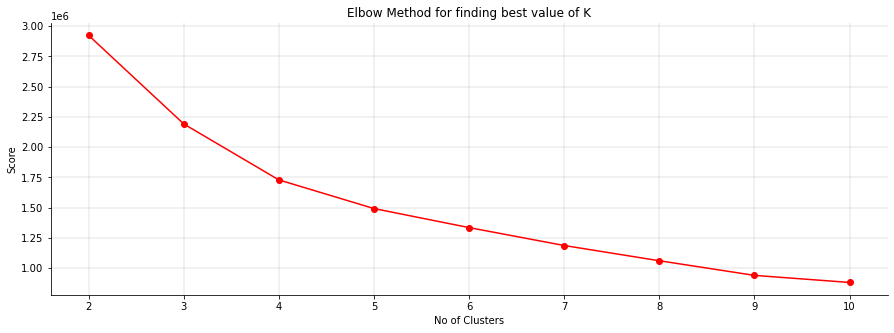

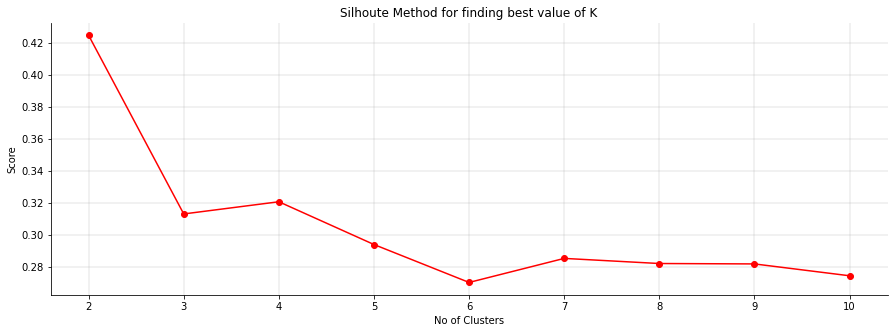

In [44]:
elbowMethodResult(train_features)
avgSilhouteMethodResult(train_features)

In [45]:
kmean_classifier = KMeans(n_clusters=3)
cluster_labels = kmean_classifier.fit(train_features)

In [46]:
cluster_details = ClusterInformation(kmean_classifier, train_features, train_labels, distance_threshold=0.43)
cluster_details

Series([], Name: output, dtype: int64)
0
Series([], Name: output, dtype: int64)
0
Series([], Name: output, dtype: int64)
0


[{'K': 1,
  'centroid': array([5.38562197e+01, 5.91276252e-01, 1.37479806e+00, 1.33016155e+02,
         2.49520194e+02, 1.58319871e-01, 4.62035541e-01, 1.57474960e+02,
         1.69628433e-01, 6.23747981e-01, 1.50403877e+00, 4.34571890e-01,
         2.15670436e+00]),
  'total_classes': array([], dtype=int64)},
 {'K': 2,
  'centroid': array([5.14649266e+01, 6.31321370e-01, 1.29363785e+00, 1.26631321e+02,
         1.97221860e+02, 1.45187602e-01, 7.37357259e-01, 1.55378467e+02,
         1.99021207e-01, 6.84502447e-01, 1.55464927e+00, 3.81729201e-01,
         2.11908646e+00]),
  'total_classes': array([], dtype=int64)},
 {'K': 3,
  'centroid': array([5.53539095e+01, 4.03292181e-01, 1.09053498e+00, 1.30724280e+02,
         3.29292181e+02, 9.87654321e-02, 6.70781893e-01, 1.57205761e+02,
         1.31687243e-01, 8.90534979e-01, 1.62551440e+00, 5.06172840e-01,
         2.16049383e+00]),
  'total_classes': array([], dtype=int64)}]

In [47]:
predictions = UnseenFoldPrediction(kmean_classifier, unseen_fold_features, 0.43)
predictions = CleanPredictions(predictions)
calculate_confusion_matrix(unseen_fold_labels, predictions, labels=HID1["output"].unique())

KeyError: 'minority_class'

### Airline Passenger Satisfaction

In [100]:
df2 = pd.read_csv("airline_passenger_satisfaction/train.csv")
print(df2.shape)
df2.head(10)

(103904, 25)


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied
5,5,111157,Female,Loyal Customer,26,Personal Travel,Eco,1180,3,4,...,1,3,4,4,4,4,1,0,0.0,neutral or dissatisfied
6,6,82113,Male,Loyal Customer,47,Personal Travel,Eco,1276,2,4,...,2,3,3,4,3,5,2,9,23.0,neutral or dissatisfied
7,7,96462,Female,Loyal Customer,52,Business travel,Business,2035,4,3,...,5,5,5,5,4,5,4,4,0.0,satisfied
8,8,79485,Female,Loyal Customer,41,Business travel,Business,853,1,2,...,1,1,2,1,4,1,2,0,0.0,neutral or dissatisfied
9,9,65725,Male,disloyal Customer,20,Business travel,Eco,1061,3,3,...,2,2,3,4,4,3,2,0,0.0,neutral or dissatisfied


In [101]:
df2.dtypes

Unnamed: 0                             int64
id                                     int64
Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure 

In [102]:
df2.isnull().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction    

In [103]:
df2.dropna(inplace = True)

In [104]:
df2.shape

(103594, 25)

In [105]:
df2.duplicated().sum()

0

neutral or dissatisfied : 56.660617410274725 %
satisfied : 43.339382589725275 %


43.339382589725275

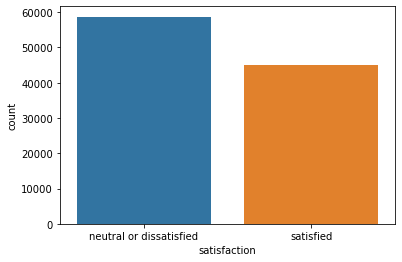

In [106]:
class_balance(df2, "satisfaction")

In [107]:
le = preprocessing.LabelEncoder()
df2["Gender"] = le.fit_transform(df2["Gender"])
df2["Customer Type"] = le.fit_transform(df2["Customer Type"])
df2["Type of Travel"] = le.fit_transform(df2["Type of Travel"])
df2["satisfaction"] = le.fit_transform(df2["satisfaction"])
df2 = pd.get_dummies(df2, columns= ['Class'])
df2.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Class_Business,Class_Eco,Class_Eco Plus
0,0,70172,1,0,13,1,460,3,4,3,...,4,4,5,5,25,18.0,0,0,0,1
1,1,5047,1,1,25,0,235,3,2,3,...,3,1,4,1,1,6.0,0,1,0,0
2,2,110028,0,0,26,0,1142,2,2,2,...,4,4,4,5,0,0.0,1,1,0,0
3,3,24026,0,0,25,0,562,2,5,5,...,3,1,4,2,11,9.0,0,1,0,0
4,4,119299,1,0,61,0,214,3,3,3,...,4,3,3,3,0,0.0,1,1,0,0


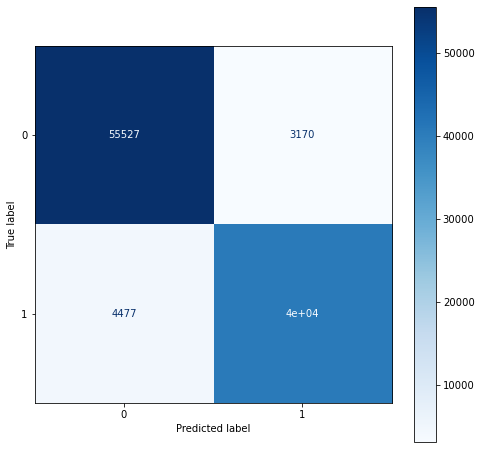

In [108]:
features, labels = features_labels(df2, label_column="satisfaction")
test_labels, pred_labels = train_test_model(randomForestClassifier, stratified_kfolds, features, labels)

calculate_confusion_matrix(test_labels, pred_labels, labels=df2["satisfaction"].unique())

In [109]:
stratified_kfolds = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    
unseen_fold_train_indices = np.empty([0], dtype=int)
unseen_fold_test_indices = np.empty([0], dtype=int)
train_fold_indices = np.empty([0], dtype=int)
test_fold_indices = np.empty([0], dtype=int)
    
kFold = 0
for train_index, test_index in stratified_kfolds.split(features, labels):
    if kFold == 0:
        unseen_fold_train_indices = np.append(unseen_fold_train_indices, train_index)
        unseen_fold_test_indices = np.append(unseen_fold_test_indices, test_index)
    else:
        train_fold_indices = np.append(train_fold_indices, train_index)
        test_fold_indices = np.append(test_fold_indices, test_index)
        
    kFold += 1
#print(train_fold_indices)

In [110]:
train_features = features.iloc[train_fold_indices]
train_labels = labels.iloc[train_fold_indices]

unseen_fold_features = features.iloc[unseen_fold_train_indices]
unseen_fold_labels = labels.iloc[unseen_fold_train_indices]

In [ ]:
elbowMethodResult(train_features)
avgSilhouteMethodResult(train_features)

In [ ]:
kmean_classifier = KMeans(n_clusters=3)
cluster_labels = kmean_classifier.fit(train_features)

In [ ]:
cluster_details = ClusterInformation(kmean_classifier, train_features, train_labels, distance_threshold=0.43)
cluster_details

In [ ]:
predictions = UnseenFoldPrediction(kmean_classifier, unseen_fold_features, 0.43)
predictions = CleanPredictions(predictions)
calculate_confusion_matrix(unseen_fold_labels, predictions, labels=df2["satisfaction"].unique())

### Low Imbalance (65%)

In [ ]:
output = df2.index[df2["satisfaction"] == "satisfied"]

In [ ]:
LID2 = df2.drop(output[:int(len(output) * .299)])
LID2

In [ ]:
class_balance(LID2, "satisfaction")

In [ ]:
features, labels = features_labels(LID2, label_column="satisfaction")
test_labels, pred_labels = train_test_model(randomForestClassifier, stratified_kfolds, features, labels)

calculate_confusion_matrix(test_labels, pred_labels, labels=LID2["satisfaction"].unique())

In [ ]:
stratified_kfolds = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    
unseen_fold_train_indices = np.empty([0], dtype=int)
unseen_fold_test_indices = np.empty([0], dtype=int)
train_fold_indices = np.empty([0], dtype=int)
test_fold_indices = np.empty([0], dtype=int)
    
kFold = 0
for train_index, test_index in stratified_kfolds.split(features, labels):
    if kFold == 0:
        unseen_fold_train_indices = np.append(unseen_fold_train_indices, train_index)
        unseen_fold_test_indices = np.append(unseen_fold_test_indices, test_index)
    else:
        train_fold_indices = np.append(train_fold_indices, train_index)
        test_fold_indices = np.append(test_fold_indices, test_index)
        
    kFold += 1
#print(train_fold_indices)

In [ ]:
train_features = features.iloc[train_fold_indices]
train_labels = labels.iloc[train_fold_indices]

unseen_fold_features = features.iloc[unseen_fold_train_indices]
unseen_fold_labels = labels.iloc[unseen_fold_train_indices]

In [ ]:
elbowMethodResult(train_features)
avgSilhouteMethodResult(train_features)

In [ ]:
kmean_classifier = KMeans(n_clusters=3)
cluster_labels = kmean_classifier.fit(train_features)

In [ ]:
cluster_details = ClusterInformation(kmean_classifier, train_features, train_labels, distance_threshold=0.43)
cluster_details

In [ ]:
predictions = UnseenFoldPrediction(kmean_classifier, unseen_fold_features, 0.43)
predictions = CleanPredictions(predictions)
calculate_confusion_matrix(unseen_fold_labels, predictions, labels=LID2["satisfaction"].unique())

### Medium Imbalance (75%)

In [ ]:
MID2 = df2.drop(output[:int(len(output) * .565)])
MID2

In [ ]:
class_balance(MID2, "satisfaction")

In [ ]:
features, labels = features_labels(MID2, label_column="satisfaction")
test_labels, pred_labels = train_test_model(randomForestClassifier, stratified_kfolds, features, labels)

calculate_confusion_matrix(test_labels, pred_labels, labels=MID2["satisfaction"].unique())

In [ ]:
stratified_kfolds = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    
unseen_fold_train_indices = np.empty([0], dtype=int)
unseen_fold_test_indices = np.empty([0], dtype=int)
train_fold_indices = np.empty([0], dtype=int)
test_fold_indices = np.empty([0], dtype=int)
    
kFold = 0
for train_index, test_index in stratified_kfolds.split(features, labels):
    if kFold == 0:
        unseen_fold_train_indices = np.append(unseen_fold_train_indices, train_index)
        unseen_fold_test_indices = np.append(unseen_fold_test_indices, test_index)
    else:
        train_fold_indices = np.append(train_fold_indices, train_index)
        test_fold_indices = np.append(test_fold_indices, test_index)
        
    kFold += 1
#print(train_fold_indices)

In [ ]:
train_features = features.iloc[train_fold_indices]
train_labels = labels.iloc[train_fold_indices]

unseen_fold_features = features.iloc[unseen_fold_train_indices]
unseen_fold_labels = labels.iloc[unseen_fold_train_indices]

In [ ]:
elbowMethodResult(train_features)
avgSilhouteMethodResult(train_features)

In [ ]:
kmean_classifier = KMeans(n_clusters=3)
cluster_labels = kmean_classifier.fit(train_features)

In [ ]:
cluster_details = ClusterInformation(kmean_classifier, train_features, train_labels, distance_threshold=0.43)
cluster_details

In [ ]:
predictions = UnseenFoldPrediction(kmean_classifier, unseen_fold_features, 0.43)
predictions = CleanPredictions(predictions)
compute_confusion_matrix(unseen_fold_labels, predictions, labels=MID2["satisfaction"].unique())

### High imbalance (90%)

In [ ]:
HID2 = df2.drop(output[:int(len(output) * 0.856)])
HID2

In [ ]:
class_balance(HID2, "satisfaction")

In [ ]:
features, labels = features_labels(HID2, label_column="satisfaction")
test_labels, pred_labels = train_test_model(randomForestClassifier, stratified_kfolds, features, labels)

calculate_confusion_matrix(test_labels, pred_labels, labels=HID2["satisfaction"].unique())

In [ ]:
stratified_kfolds = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    
unseen_fold_train_indices = np.empty([0], dtype=int)
unseen_fold_test_indices = np.empty([0], dtype=int)
train_fold_indices = np.empty([0], dtype=int)
test_fold_indices = np.empty([0], dtype=int)
    
kFold = 0
for train_index, test_index in stratified_kfolds.split(features, labels):
    if kFold == 0:
        unseen_fold_train_indices = np.append(unseen_fold_train_indices, train_index)
        unseen_fold_test_indices = np.append(unseen_fold_test_indices, test_index)
    else:
        train_fold_indices = np.append(train_fold_indices, train_index)
        test_fold_indices = np.append(test_fold_indices, test_index)
        
    kFold += 1
#print(train_fold_indices)

In [ ]:
train_features = features.iloc[train_fold_indices]
train_labels = labels.iloc[train_fold_indices]

unseen_fold_features = features.iloc[unseen_fold_train_indices]
unseen_fold_labels = labels.iloc[unseen_fold_train_indices]

In [ ]:
elbowMethodResult(train_features)
avgSilhouteMethodResult(train_features)

In [ ]:
kmean_classifier = KMeans(n_clusters=3)
cluster_labels = kmean_classifier.fit(train_features)

In [ ]:
cluster_details = ClusterInformation(kmean_classifier, train_features, train_labels, distance_threshold=0.43)
cluster_details

In [ ]:
predictions = UnseenFoldPrediction(kmean_classifier, unseen_fold_features, 0.43)
predictions = CleanPredictions(predictions)
calculate_confusion_matrix(unseen_fold_labels, predictions, labels=HID2["satisfaction"].unique())

## Raisin Dataset

In [48]:
df3 = pd.read_csv("raisin_dataset/raisin_dataset.csv")
print(df3.shape)
df3.head(10)

(900, 8)


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen
5,49242,318.125407,200.122120,0.777351,51368,0.658456,881.836,Kecimen
6,42492,310.146072,176.131449,0.823099,43904,0.665894,823.796,Kecimen
7,60952,332.455472,235.429835,0.706058,62329,0.743598,933.366,Kecimen
8,42256,323.189607,172.575926,0.845499,44743,0.698031,849.728,Kecimen
9,64380,366.964842,227.771615,0.784056,66125,0.664376,981.544,Kecimen


In [49]:
df3.dtypes

Area                 int64
MajorAxisLength    float64
MinorAxisLength    float64
Eccentricity       float64
ConvexArea           int64
Extent             float64
Perimeter          float64
Class               object
dtype: object

In [50]:
df3.isnull().sum()

Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
Extent             0
Perimeter          0
Class              0
dtype: int64

In [51]:
df3.duplicated().sum()

0

Kecimen : 50.0 %
Besni : 50.0 %


50.0

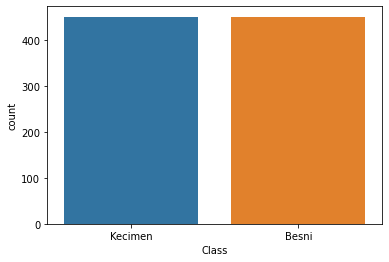

In [52]:
class_balance(df3, "Class")

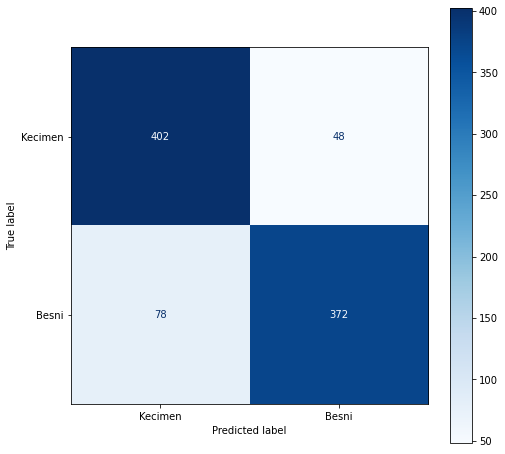

In [53]:
features, labels = features_labels(df3, label_column="Class")
test_labels, pred_labels = train_test_model(randomForestClassifier, stratified_kfolds, features, labels)

calculate_confusion_matrix(test_labels, pred_labels, labels=df3["Class"].unique())

In [54]:
stratified_kfolds = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    
unseen_fold_train_indices = np.empty([0], dtype=int)
unseen_fold_test_indices = np.empty([0], dtype=int)
train_fold_indices = np.empty([0], dtype=int)
test_fold_indices = np.empty([0], dtype=int)
    
kFold = 0
for train_index, test_index in stratified_kfolds.split(features, labels):
    if kFold == 0:
        unseen_fold_train_indices = np.append(unseen_fold_train_indices, train_index)
        unseen_fold_test_indices = np.append(unseen_fold_test_indices, test_index)
    else:
        train_fold_indices = np.append(train_fold_indices, train_index)
        test_fold_indices = np.append(test_fold_indices, test_index)
        
    kFold += 1
#print(train_fold_indices)

In [55]:
train_features = features.iloc[train_fold_indices]
train_labels = labels.iloc[train_fold_indices]

unseen_fold_features = features.iloc[unseen_fold_train_indices]
unseen_fold_labels = labels.iloc[unseen_fold_train_indices]

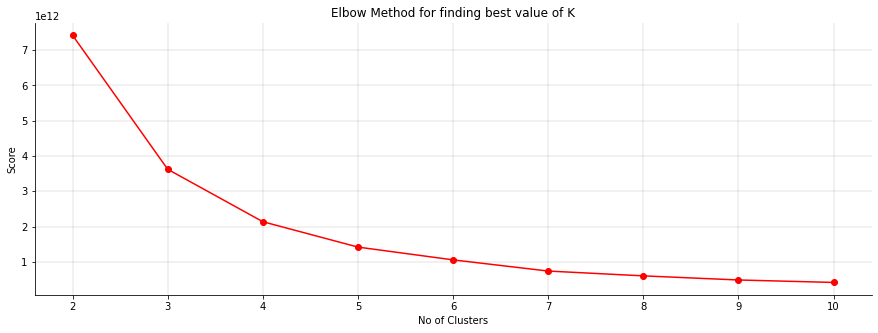

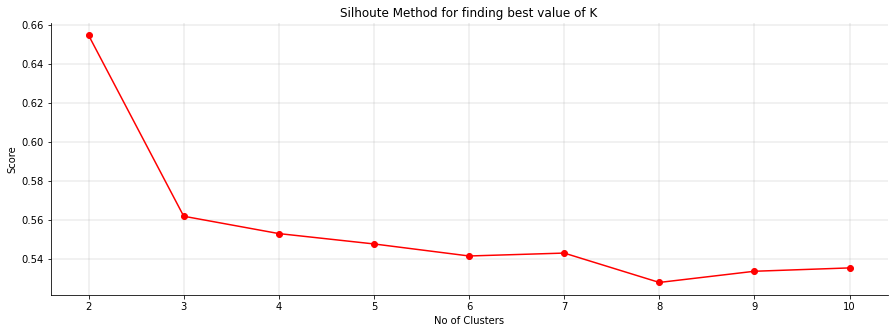

In [56]:
elbowMethodResult(train_features)
avgSilhouteMethodResult(train_features)

In [57]:
kmean_classifier = KMeans(n_clusters=3)
cluster_labels = kmean_classifier.fit(train_features)

In [58]:
cluster_details = ClusterInformation(kmean_classifier, train_features, train_labels, distance_threshold=0.43)
cluster_details

Series([], Name: Class, dtype: object)
0
Series([], Name: Class, dtype: object)
0
Series([], Name: Class, dtype: object)
0


[{'K': 1,
  'centroid': array([5.96047320e+04, 3.47639878e+02, 2.20740478e+02, 7.53235023e-01,
         6.18724026e+04, 7.02992199e-01, 9.64272633e+02]),
  'total_classes': array([], dtype=object)},
 {'K': 2,
  'centroid': array([9.97563206e+04, 4.74782579e+02, 2.72326562e+02, 8.02807949e-01,
         1.03484491e+05, 6.92681729e-01, 1.27334918e+03]),
  'total_classes': array([], dtype=object)},
 {'K': 3,
  'centroid': array([1.66443177e+05, 6.40217489e+02, 3.39894481e+02, 8.34182200e-01,
         1.73275251e+05, 7.03944547e-01, 1.67066839e+03]),
  'total_classes': array([], dtype=object)}]

In [59]:
predictions = UnseenFoldPrediction(kmean_classifier, unseen_fold_features, 0.43)
predictions = getCleanPredictions(predictions)
calculate_confusion_matrix(unseen_fold_labels, predictions, labels=df3["Class"].unique())

KeyError: 'minority_class'

###  Low imbalance (65%)

In [60]:
output = df3.index[df3["Class"] == "Kecimen"]

In [61]:
LID3 = df3.drop(output[:int(len(output) * 0.463)])
LID3

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
208,39547,259.422625,198.465531,0.643997,40765,0.733384,763.979,Kecimen
209,49998,301.780707,212.326943,0.710616,50857,0.779295,834.328,Kecimen
210,49063,294.748287,217.913109,0.673355,50732,0.658811,869.795,Kecimen
211,46961,343.788528,177.136795,0.857040,48476,0.614633,891.528,Kecimen
212,57271,372.699124,196.976135,0.848926,58786,0.769151,949.936,Kecimen
...,...,...,...,...,...,...,...,...
895,83248,430.077308,247.838695,0.817263,85839,0.668793,1129.072,Besni
896,87350,440.735698,259.293149,0.808629,90899,0.636476,1214.252,Besni
897,99657,431.706981,298.837323,0.721684,106264,0.741099,1292.828,Besni
898,93523,476.344094,254.176054,0.845739,97653,0.658798,1258.548,Besni


Kecimen : 34.971098265895954 %
Besni : 65.02890173410405 %


65.02890173410405

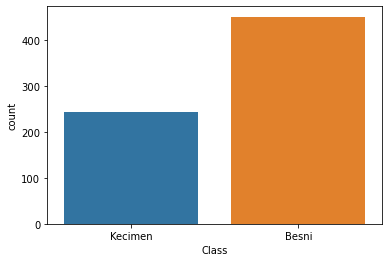

In [62]:
class_balance(LID3, "Class")

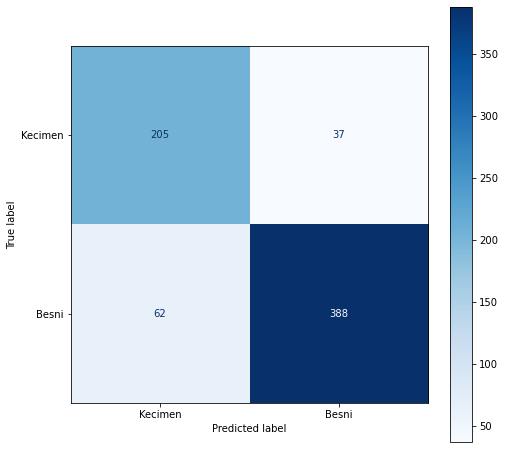

In [63]:
features, labels = features_labels(LID3, label_column="Class")
test_labels, pred_labels = train_test_model(randomForestClassifier, stratified_kfolds, features, labels)

calculate_confusion_matrix(test_labels, pred_labels, labels=LID3["Class"].unique())

In [64]:
stratified_kfolds = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    
unseen_fold_train_indices = np.empty([0], dtype=int)
unseen_fold_test_indices = np.empty([0], dtype=int)
train_fold_indices = np.empty([0], dtype=int)
test_fold_indices = np.empty([0], dtype=int)
    
kFold = 0
for train_index, test_index in stratified_kfolds.split(features, labels):
    if kFold == 0:
        unseen_fold_train_indices = np.append(unseen_fold_train_indices, train_index)
        unseen_fold_test_indices = np.append(unseen_fold_test_indices, test_index)
    else:
        train_fold_indices = np.append(train_fold_indices, train_index)
        test_fold_indices = np.append(test_fold_indices, test_index)
        
    kFold += 1
#print(train_fold_indices)

In [65]:
train_features = features.iloc[train_fold_indices]
train_labels = labels.iloc[train_fold_indices]

unseen_fold_features = features.iloc[unseen_fold_train_indices]
unseen_fold_labels = labels.iloc[unseen_fold_train_indices]

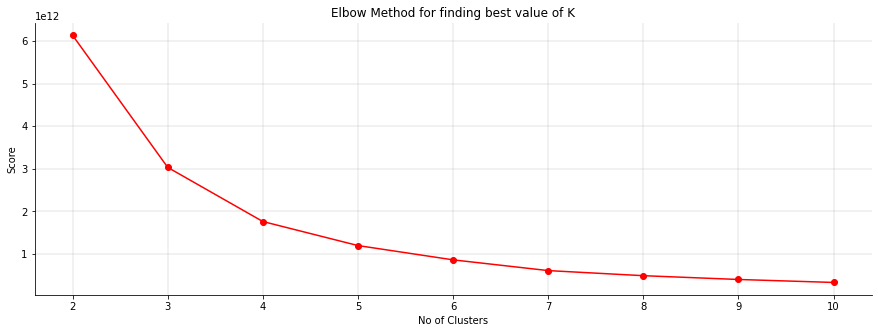

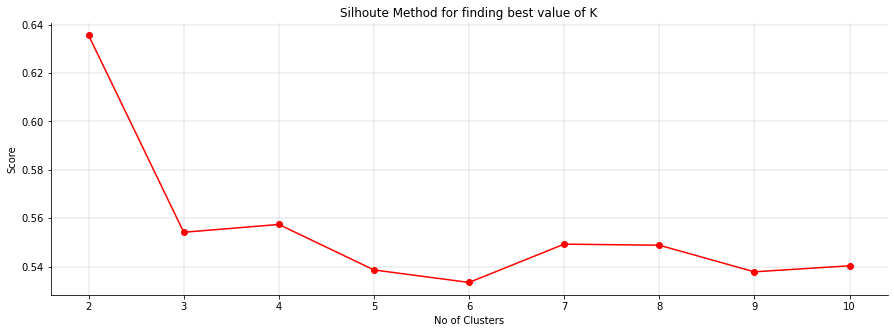

In [66]:
elbowMethodResult(train_features)
avgSilhouteMethodResult(train_features)

In [67]:
kmean_classifier = KMeans(n_clusters=3)
cluster_labels = kmean_classifier.fit(train_features)

In [68]:
cluster_details = ClusterInformation(kmean_classifier, train_features, train_labels, distance_threshold=0.43)
cluster_details

Series([], Name: Class, dtype: object)
0
Series([], Name: Class, dtype: object)
0
Series([], Name: Class, dtype: object)
0


[{'K': 1,
  'centroid': array([1.02426945e+05, 4.85928977e+02, 2.73326664e+02, 8.12697588e-01,
         1.06371305e+05, 6.89601853e-01, 1.29581372e+03]),
  'total_classes': array([], dtype=object)},
 {'K': 2,
  'centroid': array([1.67851209e+05, 6.41075955e+02, 3.41915064e+02, 8.32436152e-01,
         1.74451974e+05, 7.06285030e-01, 1.67330269e+03]),
  'total_classes': array([], dtype=object)},
 {'K': 3,
  'centroid': array([6.10707743e+04, 3.56564216e+02, 2.20629837e+02, 7.66506181e-01,
         6.35224262e+04, 6.98648166e-01, 9.81112829e+02]),
  'total_classes': array([], dtype=object)}]

In [69]:
predictions = UnseenFoldPrediction(kmean_classifier, unseen_fold_features, 0.43)
predictions = CleanPredictions(predictions)
calculate_confusion_matrix(unseen_fold_labels, predictions, labels=LID3["Class"].unique())

KeyError: 'minority_class'

### Medium imbalance (75%)

In [74]:
MID3 = df3.drop(output[:int(len(output) * 0.668)])
MID3

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
300,87429,408.926028,273.887942,0.742565,89063,0.703575,1120.019,Kecimen
301,57785,314.430977,236.183035,0.660138,58867,0.732866,903.769,Kecimen
302,69846,368.450710,243.975162,0.749358,72585,0.676724,1040.716,Kecimen
303,81456,404.316394,258.892006,0.768108,83499,0.725472,1103.153,Kecimen
304,61959,339.585018,234.697936,0.722729,64424,0.712041,970.754,Kecimen
...,...,...,...,...,...,...,...,...
895,83248,430.077308,247.838695,0.817263,85839,0.668793,1129.072,Besni
896,87350,440.735698,259.293149,0.808629,90899,0.636476,1214.252,Besni
897,99657,431.706981,298.837323,0.721684,106264,0.741099,1292.828,Besni
898,93523,476.344094,254.176054,0.845739,97653,0.658798,1258.548,Besni


Kecimen : 25.0 %
Besni : 75.0 %


75.0

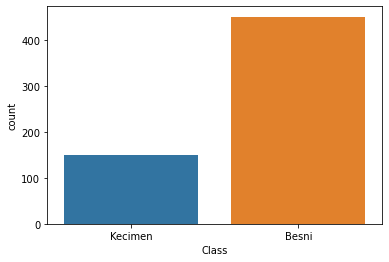

In [75]:
class_balance(MID3, "Class")

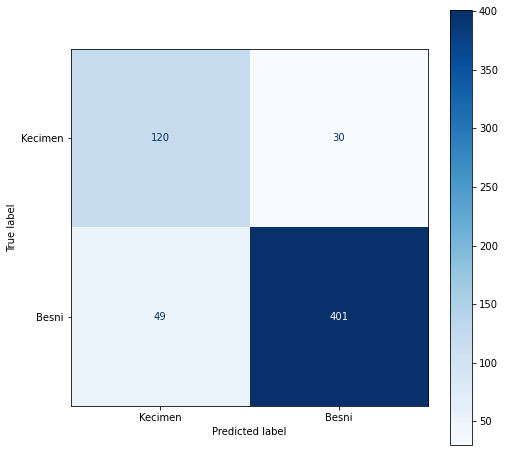

In [76]:
features, labels = features_labels(MID3, label_column="Class")
test_labels, pred_labels = train_test_model(randomForestClassifier, stratified_kfolds, features, labels)

calculate_confusion_matrix(test_labels, pred_labels, labels=MID3["Class"].unique())

In [77]:
stratified_kfolds = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    
unseen_fold_train_indices = np.empty([0], dtype=int)
unseen_fold_test_indices = np.empty([0], dtype=int)
train_fold_indices = np.empty([0], dtype=int)
test_fold_indices = np.empty([0], dtype=int)
    
kFold = 0
for train_index, test_index in stratified_kfolds.split(features, labels):
    if kFold == 0:
        unseen_fold_train_indices = np.append(unseen_fold_train_indices, train_index)
        unseen_fold_test_indices = np.append(unseen_fold_test_indices, test_index)
    else:
        train_fold_indices = np.append(train_fold_indices, train_index)
        test_fold_indices = np.append(test_fold_indices, test_index)
        
    kFold += 1
#print(train_fold_indices)

In [78]:
train_features = features.iloc[train_fold_indices]
train_labels = labels.iloc[train_fold_indices]

unseen_fold_features = features.iloc[unseen_fold_train_indices]
unseen_fold_labels = labels.iloc[unseen_fold_train_indices]

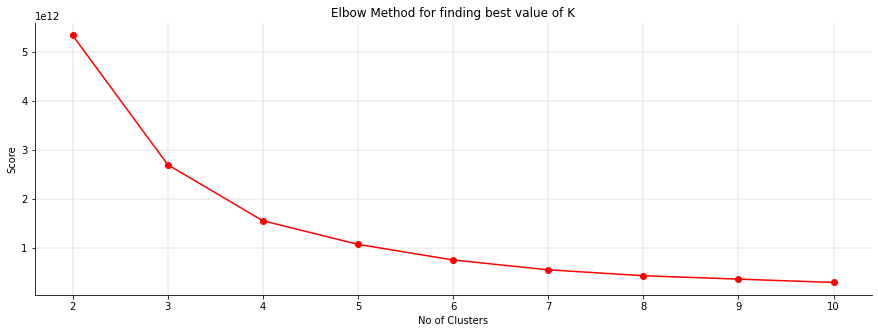

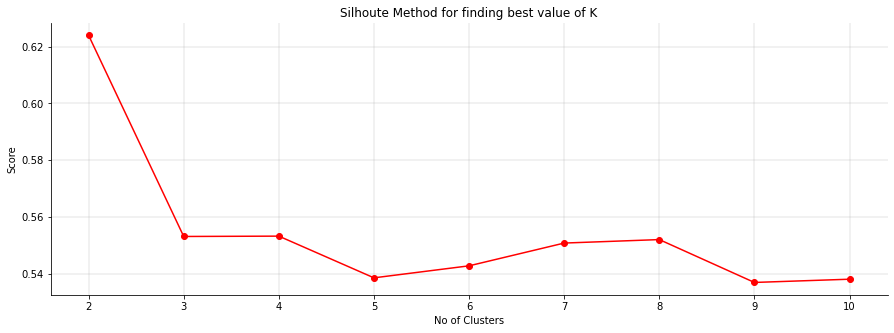

In [79]:
elbowMethodResult(train_features)
avgSilhouteMethodResult(train_features)

In [80]:
kmean_classifier = KMeans(n_clusters=3)
cluster_labels = kmean_classifier.fit(train_features)

In [81]:
cluster_details = ClusterInformation(kmean_classifier, train_features, train_labels, distance_threshold=0.43)
cluster_details

Series([], Name: Class, dtype: object)
0
Series([], Name: Class, dtype: object)
0
Series([], Name: Class, dtype: object)
0


[{'K': 1,
  'centroid': array([1.09271488e+05, 5.05750838e+02, 2.80224007e+02, 8.18988368e-01,
         1.13404794e+05, 6.90600747e-01, 1.34203887e+03]),
  'total_classes': array([], dtype=object)},
 {'K': 2,
  'centroid': array([1.70774019e+05, 6.44787719e+02, 3.45514778e+02, 8.30535247e-01,
         1.77189659e+05, 7.08949319e-01, 1.68168149e+03]),
  'total_classes': array([], dtype=object)},
 {'K': 3,
  'centroid': array([6.69068711e+04, 3.79928454e+02, 2.26845802e+02, 7.85392526e-01,
         6.96942006e+04, 6.93276736e-01, 1.03442055e+03]),
  'total_classes': array([], dtype=object)}]

In [82]:
predictions = UnseenFoldPrediction(kmean_classifier, unseen_fold_features, 0.43)
predictions = CleanPredictions(predictions)
calculate_confusion_matrix(unseen_fold_labels, predictions, labels=MID3["Class"].unique())

KeyError: 'minority_class'

### High imbalance (90%)

In [83]:
HID3 = df3.drop(output[:int(len(output) * 0.89)])
HID3

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
400,49336,338.481461,193.005202,0.821500,52619,0.656553,909.681,Kecimen
401,39368,296.655948,171.208165,0.816654,41361,0.619969,798.546,Kecimen
402,51304,350.042582,189.765438,0.840300,52949,0.660998,897.111,Kecimen
403,91764,433.768160,270.286095,0.782133,93480,0.692925,1165.084,Kecimen
404,79252,398.844564,254.172930,0.770638,80799,0.705007,1074.108,Kecimen
...,...,...,...,...,...,...,...,...
895,83248,430.077308,247.838695,0.817263,85839,0.668793,1129.072,Besni
896,87350,440.735698,259.293149,0.808629,90899,0.636476,1214.252,Besni
897,99657,431.706981,298.837323,0.721684,106264,0.741099,1292.828,Besni
898,93523,476.344094,254.176054,0.845739,97653,0.658798,1258.548,Besni


Kecimen : 10.0 %
Besni : 90.0 %


90.0

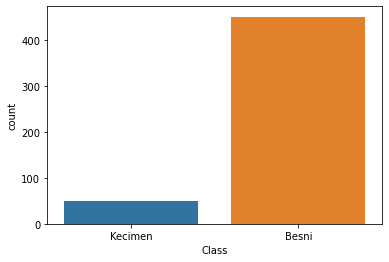

In [84]:
class_balance(HID3, "Class")

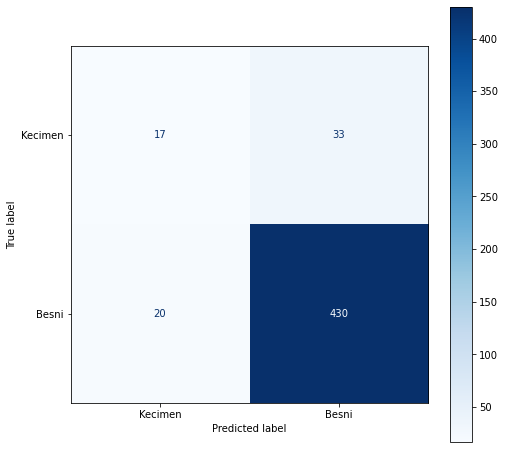

In [85]:
features, labels = features_labels(HID3, label_column="Class")
test_labels, pred_labels = train_test_model(randomForestClassifier, stratified_kfolds, features, labels)

calculate_confusion_matrix(test_labels, pred_labels, labels=HID3["Class"].unique())

In [86]:
stratified_kfolds = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    
unseen_fold_train_indices = np.empty([0], dtype=int)
unseen_fold_test_indices = np.empty([0], dtype=int)
train_fold_indices = np.empty([0], dtype=int)
test_fold_indices = np.empty([0], dtype=int)
    
kFold = 0
for train_index, test_index in stratified_kfolds.split(features, labels):
    if kFold == 0:
        unseen_fold_train_indices = np.append(unseen_fold_train_indices, train_index)
        unseen_fold_test_indices = np.append(unseen_fold_test_indices, test_index)
    else:
        train_fold_indices = np.append(train_fold_indices, train_index)
        test_fold_indices = np.append(test_fold_indices, test_index)
        
    kFold += 1
#print(train_fold_indices)

In [87]:
train_features = features.iloc[train_fold_indices]
train_labels = labels.iloc[train_fold_indices]

unseen_fold_features = features.iloc[unseen_fold_train_indices]
unseen_fold_labels = labels.iloc[unseen_fold_train_indices]

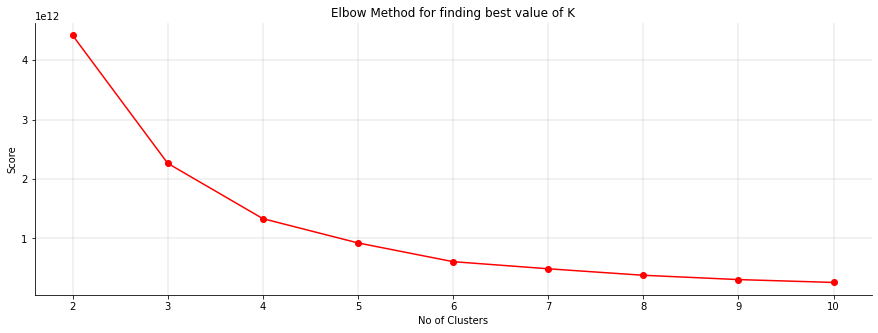

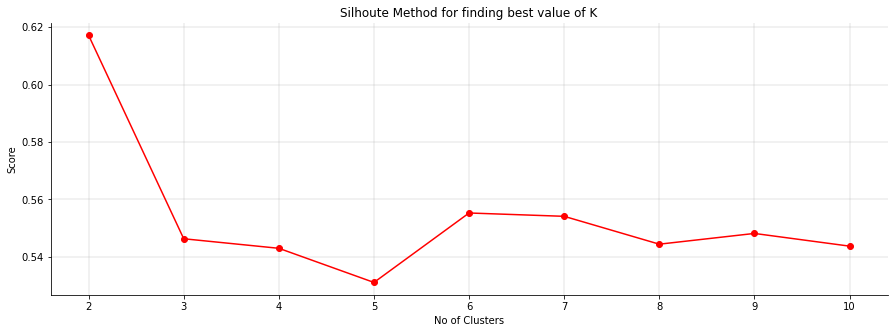

In [88]:
elbowMethodResult(train_features)
avgSilhouteMethodResult(train_features)

In [89]:
kmean_classifier = KMeans(n_clusters=3)
cluster_labels = kmean_classifier.fit(train_features)

In [90]:
cluster_details = ClusterInformation(kmean_classifier, train_features, train_labels, distance_threshold=0.43)
cluster_details

Series([], Name: Class, dtype: object)
0
Series([], Name: Class, dtype: object)
0
Series([], Name: Class, dtype: object)
0


[{'K': 1,
  'centroid': array([7.29166301e+04, 4.03850464e+02, 2.33159888e+02, 8.01176312e-01,
         7.61201841e+04, 6.86718673e-01, 1.09143908e+03]),
  'total_classes': array([], dtype=object)},
 {'K': 2,
  'centroid': array([1.77028883e+05, 6.58455405e+02, 3.51875809e+02, 8.30768809e-01,
         1.83900981e+05, 7.08856061e-01, 1.71764238e+03]),
  'total_classes': array([], dtype=object)},
 {'K': 3,
  'centroid': array([1.15944880e+05, 5.23802765e+02, 2.86886095e+02, 8.24708783e-01,
         1.20202020e+05, 6.92619742e-01, 1.38285368e+03]),
  'total_classes': array([], dtype=object)}]

In [91]:
predictions = UnseenFoldPrediction(kmean_classifier, unseen_fold_features, 0.43)
predictions = CleanPredictions(predictions)
calculate_confusion_matrix(unseen_fold_labels, predictions, labels=HID3["Class"].unique())

KeyError: 'minority_class'